# RFM Yöntemi ile Müşteri Kümeleme

In [1]:
#Kullanacağımız Kütüphaneleri import ediyoruz
import pandas as pd
from pandas import Timestamp as ts
import numpy
from pandas import read_csv
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#Verimizi pandas kütüphanesi yardımı ile okuyoruz
rfmdata= pd.read_excel('data.xlsx')

In [3]:
#Brim ücret ile adeti çarpıp toplam ücreti buluyoruz
rfmdata["TotalPrice"]=rfmdata["UnitPrice"]*rfmdata["Quantity"]
#Veri setinde bulunan tarih kullanabileceğimiz şekilde manipüle ediyoruz
rfmdata["InvoiceDate"]=pd.to_datetime(rfmdata["InvoiceDate"])
#Hatalı Gözlem varsa diye ufak bir önlem alıyoruz
rfmdata=rfmdata[rfmdata["Quantity"]>0]
rfmdata=rfmdata[rfmdata["TotalPrice"]>0]
#Veri setimizdeki tarihler 2010 yılında olduğu için zaman değerini ondan 1 yıl olarak ayarladık
today=dt.datetime(2012,5,11)

In [4]:
#Veri setimize bir göz gezdiriyoruz
rfmdata.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


In [5]:
#"CustomerID"ye göre bir gruplama yapıyoruz bunun sebebi bir müşteri için birden fazla "CustomerID" Ve "TotalPrice" var.
#("CustomerID"yi İndex olarak kabul ediyoruz gibi düşünebiliriz)
#"CustomerID"si aynı olan TotalPricelarını topluyoruz bu sayede bir müşterinin farklı siparişlerle toplam kaç para harcadığını öğreniyoruz
#Bugünün tarihinden "InvoiceDate"nin en yüksek yani en son yapılan alışveriş tarihini çıkarıyoruz
#Bu da bize son alışverişin üzerinden kaç gün geçtiğini gösteriyor
data_x = rfmdata.groupby("CustomerID").agg({"TotalPrice":lambda x: x.sum(),
                                         "InvoiceDate": lambda x: (today - x.max()).days})
#"CustomerID" ve "InvoiceNo"yi baz alarak bir gruplama yapıyoruz. 
#Bir müşterinin kaçkere alışveriş yaptığını anlamak için gruplama yapıyoruz
data_y = rfmdata.groupby(["CustomerID","InvoiceNo"]).agg({"TotalPrice":lambda x: x.sum()})
#len() Fonkisoynu ile sayma işlemini yapıyoruz
data_z = data_y.groupby("CustomerID").agg({"TotalPrice":lambda x:len(x)})

# Yukarıda yapılan işlemlerin daha iyi anlaşılması için tabloları inceleyelim

In [6]:
rfmdata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
data_y.head()

TotalPrice
CustomerID InvoiceNo            
12346.0    541431       77183.60
12347.0    537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52

In [8]:
data_z.head()
#Aşağıda TotalPrice yazdığına bakmayın bu aslında bir müşterinin kaç kere geldiğini gösteriyor

,TotalPrice
CustomerID,
12346.0,1.0
12347.0,7.0
12348.0,4.0
12349.0,1.0
12350.0,1.0


In [9]:
#Yaptığımız işlemleri daha iyi bir şekilde görmek için bir tabloda topluyoruz ve isim karışıklığı işini çözüyoruz
rfm_tables=pd.merge(data_x,data_z,on="CustomerID")
rfm_tables.rename(columns={"InvoiceDate":"Recency",
                         "TotalPrice_y":"Frequency",
                         "TotalPrice_x":"Monetary"},inplace=True)

In [10]:
rfm_tables.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,77183.60,478,1.0
12347.0,4310.00,155,7.0
12348.0,1797.24,228,4.0
12349.0,1757.55,171,1.0
12350.0,334.40,463,1.0


In [11]:
#İstatistikde kartil olarak bildiğimiz veri setini dörde bölen sistem için fonksiyon tanımlıyoruz.Fakat biz 5e bölüyoruz
def Fscore (x,p,d):
    if x <=d[p][0.20]:
        return 1
    elif x <=d[p][0.40]:
        return 2
    elif x <=d[p][0.60]:
        return 3
    elif x <=d[p][0.80]:
        return 4
    else:
        return 5
    
quantiles = rfm_tables.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()

In [12]:
#Tanımladığımız Fonkisyonu kullanarak değerlere ayırıyoruz
rfm_tables["Freq_Tile"]=rfm_tables["Frequency"].apply(Fscore,args=("Frequency",quantiles))
rfm_tables["Rec_Tile"]=rfm_tables["Recency"].apply(Fscore,args=("Recency",quantiles))

[b.loc[:,3:3]==48]=50000 

In [13]:
#Burada yaptığımız işlemin sebebi müşterinin bizden yaptığı son alışveriş tarihi ne kadar büyük olursa ,
#Makine ona daha fazla skor atıyor.
#Yani bizden 500 gün önce alışveriş yapmış biri 30 gün önce alışveriş yapmış birinden daha değerli gibi gösteriyor.
#Burada olan tersliği düzeltiyoruz

rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==1]=10
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==2]=9
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==4]=7
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==5]=6
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==10]=5
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==9]=4
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==7]=2
rfm_tables[rfm_tables.loc[:,"Rec_Tile":"Rec_Tile"]==6]=1

In [14]:
#Veri setini 5 eşit parçaya bölme işlemini pandas kütüphanesi sayesinde fonksiyon tanımlamadan da yapabiliriz 
rfm_tables=rfm_tables.sort_values("Monetary",ascending=False)
rfm_tables["Mone_Tile"]=pd.qcut(rfm_tables["Monetary"],5,labels=False)

#Pandas 5 eşit parçaya böldükten sonra 0 1 2 3 4 diye sıralıyor.Bize RFM için 1 2 3 4 5 diye gerekli
#Hepsine 1 ekleyerek bu sorunu çözüyoruz
rfm_tables["Mone_Tile"]=rfm_tables["Mone_Tile"]+1

In [15]:
rfm_tables.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile
CustomerID,,,,,,
14646.0,280206.02,154,73.0,5,5,5
18102.0,259657.30,153,60.0,5,5,5
17450.0,194550.79,161,46.0,5,5,5
16446.0,168472.50,153,2.0,2,5,5
14911.0,143825.06,154,201.0,5,5,5


In [16]:
#Bu puanlama sistemlerini birleştirerek RFM Skorumuzu öğreniyoruz
rfm_tables["RFM Score"]=rfm_tables["Rec_Tile"].map(str)+rfm_tables["Freq_Tile"].map(str)+rfm_tables["Mone_Tile"].map(str)


In [17]:
#RFM Skorlarını İstatiksel olarak incelemeek için "RFM Score"a göre gruplayıp inceliyoruz
rfm_tables.groupby("RFM Score").agg({"Recency":["mean","min","max","count"],
                                    "Frequency":["mean","min","max","count"],
                                    "Monetary":["mean","min","max","count"]}).round(1).head()

Recency                 Frequency                 Monetary          \
             mean  min  max count      mean  min  max count     mean     min   
RFM Score                                                                      
111         435.5  333  526   330       1.0  1.0  1.0   330    146.4     3.8   
112         430.5  337  526   208       1.0  1.0  1.0   208    349.8   251.2   
113         423.1  335  524    56       1.0  1.0  1.0    56    643.6   492.6   
114         427.7  358  525    21       1.0  1.0  1.0    21   1364.2  1017.7   
115         447.0  349  489     4       1.0  1.0  1.0     4  21277.6  2169.4   

                          
               max count  
RFM Score                 
111          250.0   330  
112          489.6   208  
113          931.5    56  
114         2044.4    21  
115        77183.6     4

In [18]:
#Bir RFM skoruna sahip kaç müşteri olduğunu öğreniyoruz
rfm_tables.groupby("RFM Score").size().sort_values(ascending=False)[:10]

RFM Score
111    330
555    324
112    208
455    152
211    146
311    129
444    113
212    108
544    106
312    103
dtype: int64

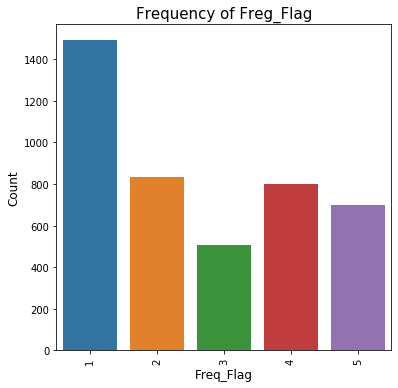

In [19]:
#Sıklık değerini grafiksel olarak inceliyoruz
plt.figure(figsize=(6,6))
sns.countplot(x="Freq_Tile",data=rfm_tables)
plt.ylabel("Count",fontsize=12)
plt.xlabel("Freq_Flag",fontsize=12)
plt.xticks(rotation="vertical")
plt.title("Frequency of Freg_Flag",fontsize=15)
plt.show()

# RFM değerlerini tek tek grafiklerde inceliyoruz

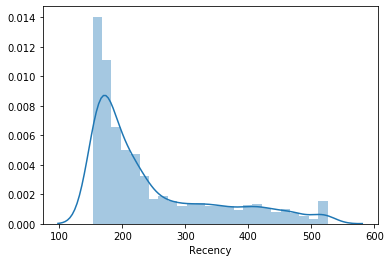

In [20]:
sns.distplot(rfm_tables["Recency"])
plt.show()

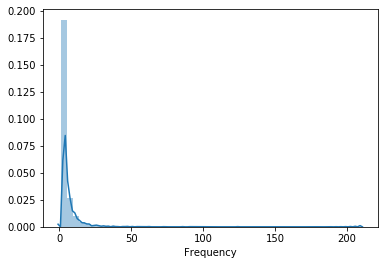

In [21]:
sns.distplot(rfm_tables["Frequency"])
plt.show()

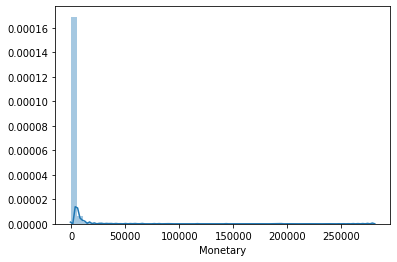

In [22]:
sns.distplot(rfm_tables["Monetary"])
plt.show()

In [23]:
rfm_tables.head(10)

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
14646.0,280206.02,154,73.0,5,5,5,555
18102.0,259657.30,153,60.0,5,5,5,555
17450.0,194550.79,161,46.0,5,5,5,555
16446.0,168472.50,153,2.0,2,5,5,525
14911.0,143825.06,154,201.0,5,5,5,555
12415.0,124914.53,177,21.0,5,4,5,455
14156.0,117379.63,162,55.0,5,5,5,555
17511.0,91062.38,155,31.0,5,5,5,555
16029.0,81024.84,191,63.0,5,3,5,355


In [24]:
#rfm_tables DataFrame inin içinden 3 değişkeni clus DataFrameine aktarıyoruz
clus=rfm_tables[["Monetary","Recency","Frequency"]]

In [25]:
clus.head()

,Monetary,Recency,Frequency
CustomerID,,,
14646.0,280206.02,154,73.0
18102.0,259657.30,153,60.0
17450.0,194550.79,161,46.0
16446.0,168472.50,153,2.0
14911.0,143825.06,154,201.0


In [26]:
#Burda bir normalizasyon işlemi yapıyoruz
#Bunu yapma sebebimiz örnek olarak 14646 CustomerID ye sahip kişiyi inceleyelim;
#280206.02 Monetary ye sahip fakat recency değeri 154 Frequency 73.0
#Monetary ile diğer değerler arasındaki fark çok yüksek olduğu için buda ilerde yapacağımız işlemlerde sıkıntı olabilir
min_max_scaler=MinMaxScaler()
x_scaled=min_max_scaler.fit_transform(clus)
data_scaled2=pd.DataFrame(x_scaled)

In [27]:
data_scaled2.head()

,0,1,2
0,1.000000,0.002681,0.346154
1,0.926665,0.000000,0.283654
2,0.694309,0.021448,0.216346
3,0.601240,0.000000,0.004808
4,0.513277,0.002681,0.961538


In [28]:
#Normalizasyon yapılmış veriyi inceliyoruz
#ve min max değerlerine bakarak sağlamasını yapıyoruz
data_scaled2.describe()

,0,1,2
count,4338.000000,4338.000000,4338.000000
mean,0.007318,0.246808,0.015731
std,0.032081,0.268129,0.037010
min,0.000000,0.000000,0.000000
25%,0.001084,0.045576,0.000000
50%,0.002394,0.134048,0.004808
75%,0.005917,0.380027,0.019231
max,1.000000,1.000000,1.000000


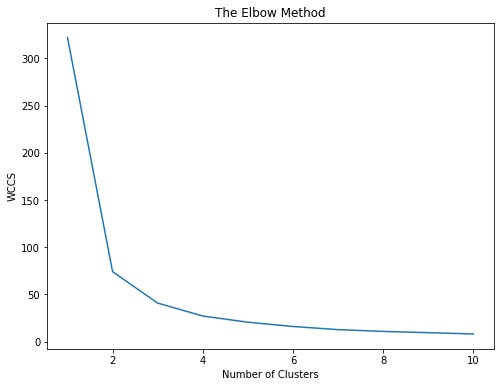

In [29]:
#The Elbow Methodu ile Kaç kümeye böleceğimizi anlamaya çalışıyoruz
plt.figure(figsize=(8,6))
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters =i,init="k-means++",n_init=10,max_iter=300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCCS")
plt.show()

In [30]:
interia_list=[]
silhouette_score_list=[]
for i in range(2,10):
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)

[0.48962683643827726]
[0.48962683643827726, 0.4858115581333478]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418, 0.48687414866763257]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418, 0.48687414866763257, 0.4734981415792655]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418, 0.48687414866763257, 0.4734981415792655, 0.4994292241716993]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418, 0.48687414866763257, 0.4734981415792655, 0.4994292241716993, 0.47524714749430347]
[0.48962683643827726, 0.4858115581333478, 0.4822931577851418, 0.48687414866763257, 0.4734981415792655, 0.4994292241716993, 0.47524714749430347, 0.47080011031137514]


In [31]:
#3 Ve 4 küme yi deniyoruz ve 4'ün bizim için daha iyi olduğuna karar veriyoruz
kmeans=KMeans(n_clusters =4, init="k-means++",n_init =10,max_iter=300)
kmeans.fit(data_scaled2)
pred=kmeans.predict(data_scaled2)

In [32]:
#Bir kümeye düşmüş kaç kişi var onu hesaplıyoruz
d_frame=pd.DataFrame(clus)
d_frame["cluster"]=pred
d_frame["cluster"].value_counts()

0    2207
2    1036
1     598
3     497
Name: cluster, dtype: int64

In [33]:
#Kümelerin ortalama değerlerini alıyoruz
d_frame.groupby("cluster").mean()

,Monetary,Recency,Frequency
cluster,,,
0,3239.310644,172.817852,6.357046
1,721.201958,346.018395,1.864548
2,1012.852811,236.854247,2.621622
3,566.710322,461.486922,1.350101


In [36]:
#Hangi üyenin hangi kümeye dahil olduğuna bakıyoruz
print(d_frame)

             Monetary  Recency  Frequency  cluster
CustomerID                                        
14646.0     280206.02      154       73.0        0
18102.0     259657.30      153       60.0        0
17450.0     194550.79      161       46.0        0
16446.0     168472.50      153        2.0        0
14911.0     143825.06      154      201.0        0
...               ...      ...        ...      ...
16878.0         13.30      237        1.0        2
17956.0         12.75      402        1.0        1
16454.0          6.90      197        2.0        0
14792.0          6.20      216        1.0        2
16738.0          3.75      450        1.0        3

[4338 rows x 4 columns]
